In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

In [8]:
def normalization(train_images, test_images):
    mean = np.mean(train_images, axis=(0, 1, 2, 3))
    std = np.std(train_images, axis=(0, 1, 2, 3))
    train_images = (train_images - mean) / (std + 1e-7)
    test_images = (test_images - mean) / (std + 1e-7)
    return train_images, test_images

def load_images():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)
    train_labels = to_categorical(train_labels, num_classes=10)
    test_labels = to_categorical(test_labels, num_classes=10)


    return train_images, train_labels, test_images, test_labels

class ConvBNRelu(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME', weight_decay=0.0005, rate=0.4, drop=True):
        super(ConvBNRelu, self).__init__()
        self.drop = drop
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                                           padding=padding, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(rate=rate)

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = tf.nn.relu(x)
        x = self.batchnorm(x, training=training)
        if self.drop:
            x = self.dropout(x, training=training)
        return x

In [9]:
class VGGModel(tf.keras.Model):
    def __init__(self):
        super(VGGModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=64, kernel_size=[3, 3], rate=0.3)
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], drop=False)
        self.maxPooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3])
        self.conv4 = ConvBNRelu(filters=128, kernel_size=[3, 3], drop=False)
        self.maxPooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv5 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv6 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv7 = ConvBNRelu(filters=256, kernel_size=[3, 3], drop=False)
        self.maxPooling3 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv8 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv9 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv10 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling4 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv11 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv12 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv13 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling5 = keras.layers.MaxPooling2D(pool_size=(2, 2))

        # Add a Flatten layer to transition from 4D to 2D
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00005))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dense2 = keras.layers.Dense(units=10)  # Output layer
        self.softmax = keras.layers.Activation('softmax')

    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.conv2(net)
        net = self.maxPooling1(net)
        net = self.conv3(net)
        net = self.conv4(net)
        net = self.maxPooling2(net)
        net = self.conv5(net)
        net = self.conv6(net)
        net = self.conv7(net)
        net = self.maxPooling3(net)
        net = self.conv8(net)
        net = self.conv9(net)
        net = self.conv10(net)
        net = self.maxPooling4(net)
        net = self.conv11(net)
        net = self.conv12(net)
        net = self.conv13(net)
        net = self.maxPooling5(net)
        net = self.flatten(net)  # Flatten the output before Dense layers
        net = self.dense1(net)
        net = self.batchnorm(net)
        net = self.dense2(net)
        net = self.softmax(net)
        return net

In [10]:
def train_and_save_history(model, train_images, train_labels, test_images, test_labels, datagen, training_epochs, batch_size, reduce_lr):
    # Train the model and capture the history
    history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                        epochs=training_epochs, verbose=2, callbacks=[reduce_lr],
                        steps_per_epoch=train_images.shape[0] // batch_size,
                        validation_data=(test_images, test_labels))

    # Save model weights
    model.save_weights('cifar10vgg_custom.weights.h5')


    # Save history to a file
    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    return history

In [13]:
if __name__ == '__main__':

    training_epochs = 200
    batch_size = 128
    learning_rate = 0.1
    momentum = 0.9
    lr_decay = 1e-6
    lr_drop = 20

    tf.random.set_seed(777)

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    train_images, train_labels, test_images, test_labels = load_images()

    # Data augmentation
    datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = 15,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False)

    datagen.fit(train_images)

    model = VGGModel()

    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, nesterov = True)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [14]:
    # Train the model and save history
    history = train_and_save_history(model, train_images, train_labels, test_images, test_labels, datagen, training_epochs, batch_size, reduce_lr)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conv_bn_relu_27', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conv_bn_relu_29', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conv_bn_relu_32', however the lay

390/390 - 72s - 184ms/step - accuracy: 0.2563 - loss: 15.5201 - val_accuracy: 0.1113 - val_loss: 12.4762 - learning_rate: 0.1000
Epoch 2/200
390/390 - 2s - 6ms/step - accuracy: 0.3672 - loss: 10.9328 - val_accuracy: 0.1132 - val_loss: 12.5734 - learning_rate: 0.1000
Epoch 3/200
390/390 - 41s - 105ms/step - accuracy: 0.3919 - loss: 8.0855 - val_accuracy: 0.1296 - val_loss: 7.5116 - learning_rate: 0.1000
Epoch 4/200
390/390 - 2s - 6ms/step - accuracy: 0.4922 - loss: 5.7562 - val_accuracy: 0.1369 - val_loss: 7.3603 - learning_rate: 0.1000
Epoch 5/200
390/390 - 41s - 105ms/step - accuracy: 0.4910 - loss: 4.4802 - val_accuracy: 0.2217 - val_loss: 5.2912 - learning_rate: 0.1000
Epoch 6/200
390/390 - 2s - 6ms/step - accuracy: 0.4688 - loss: 3.5932 - val_accuracy: 0.2238 - val_loss: 5.1036 - learning_rate: 0.1000
Epoch 7/200
390/390 - 80s - 204ms/step - accuracy: 0.5592 - loss: 2.8075 - val_accuracy: 0.5752 - val_loss: 2.4084 - learning_rate: 0.1000
Epoch 8/200
390/390 - 2s - 6ms/step - accura

Test Accuracy: 92.48%
Test Loss: 0.5106
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


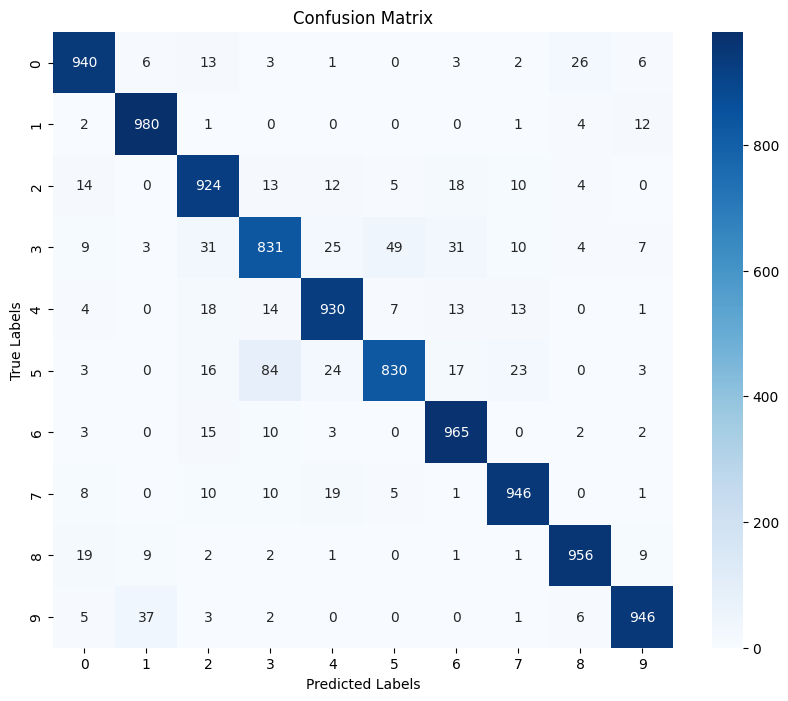

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1000
           1       0.95      0.98      0.96      1000
           2       0.89      0.92      0.91      1000
           3       0.86      0.83      0.84      1000
           4       0.92      0.93      0.92      1000
           5       0.93      0.83      0.88      1000
           6       0.92      0.96      0.94      1000
           7       0.94      0.95      0.94      1000
           8       0.95      0.96      0.96      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



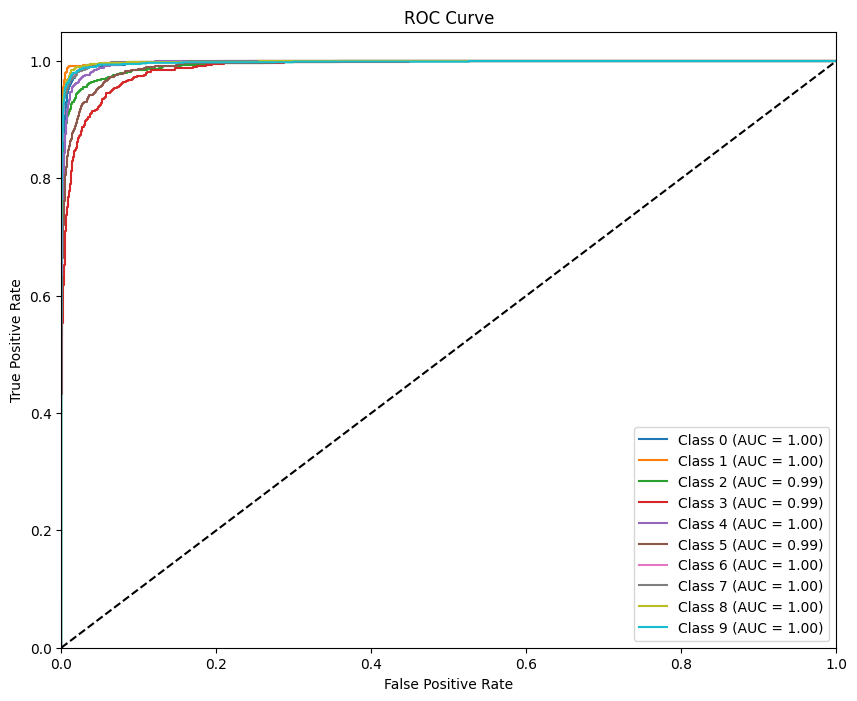

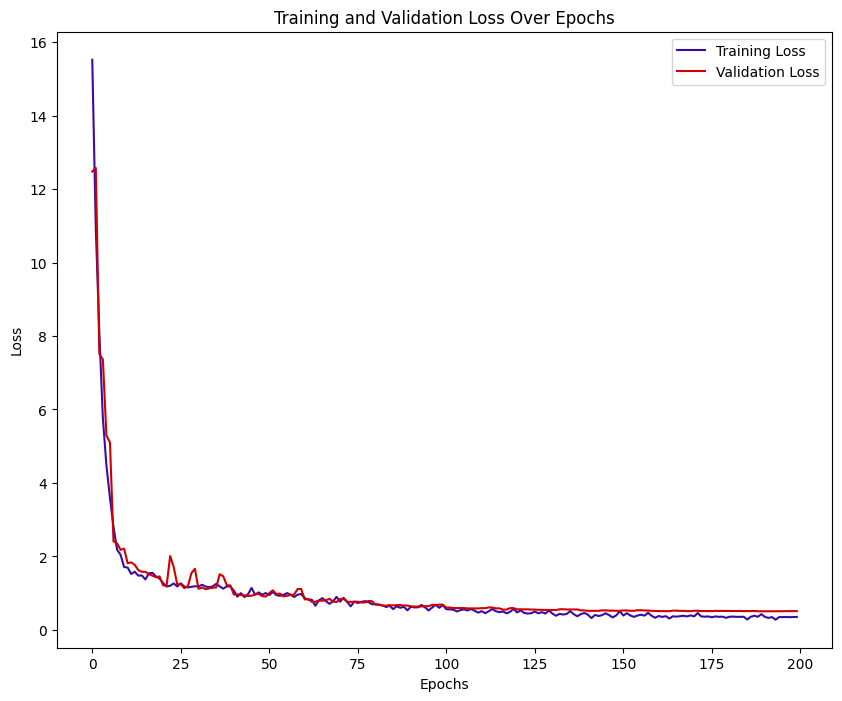

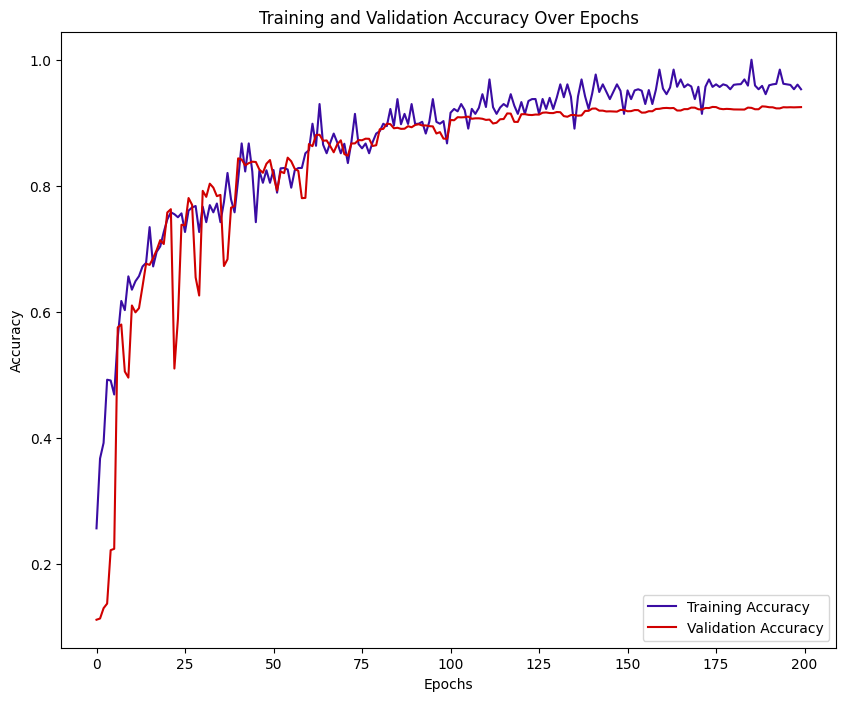

In [18]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
import numpy as np

# Load the trained model weights
model.load_weights('cifar10vgg_custom.weights.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predict the test data
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

# ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curve
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Load the history from the JSON file
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Plotting training & validation loss over epochs
plt.figure(figsize=(10, 8))
plt.plot(history['loss'], label='Training Loss', color='#3a0ca3')
plt.plot(history['val_loss'], label='Validation Loss', color='#d00000')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plotting training & validation accuracy over epochs
plt.figure(figsize=(10, 8))
plt.plot(history['accuracy'], label='Training Accuracy', color='#3a0ca3')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='#d00000')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()